## Siamese Neural Networks 
### for Supervised Clustering of High Dimensional Spaces

In [1]:
!python -V
!which python

Python 3.8.5
/Users/seanmacrae/mobius/.venv/bin/python


In [2]:
# import pandas as pd

# # DOWNLOAD DATSET HERE: https://www.kaggle.com/husainsb/lendingclub-issued-loans
# wines = pd.read_csv("../data/winequality-red.csv")

# print(wines.shape)
# wines.head()

In [3]:
from palmerpenguins import load_penguins
wines = load_penguins()

print(wines.shape)
wines.head()

(344, 8)


,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007


## Tabular Learner

Before we train the Tabular Siamese Learner we will train baseline Tabular Learner for species classification... (why do we do this, exactly? can we just instantiate a Tabular Siamese Learner without a baseline Tabular Learner ???)

Ah yes, to init a new `TabularSiameseModel` we need to provide an `encoder` and `head` and the Tabular Learner will act as the `encoder` we init the `TabularSiameseModel` with.

In [4]:
# from sklearn.model_selection import train_test_split

# wines_train, wines_test = train_test_split(
#     wines,
#     test_size=0.10,
#     stratify=wines["quality"])

# wines_train.shape, wines_test.shape

df = wines.copy()

exclude_vars = ["species"]

In [5]:
from fastai.tabular.all import CategoryBlock
                                
y_names = ["species"]
y_block = CategoryBlock()

In [6]:
from mobius.utils import emb_sz_rule

cat_names = [x for x in df.select_dtypes(exclude=['int', 'float']).columns if x != y_names]
cat_names = [x for x in cat_names if x not in exclude_vars]

# calc embedding sizes for each categorical feature
emb_szs = {k: emb_sz_rule(len(df[k].unique())) for k in cat_names}
emb_szs

{'island': 3, 'sex': 3}

In [7]:
import numpy as np

cont_names = [x for x in df.select_dtypes([np.number]).columns if x != y_names]
cont_names = [x for x in cont_names if x not in exclude_vars]
cont_names

['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g', 'year']

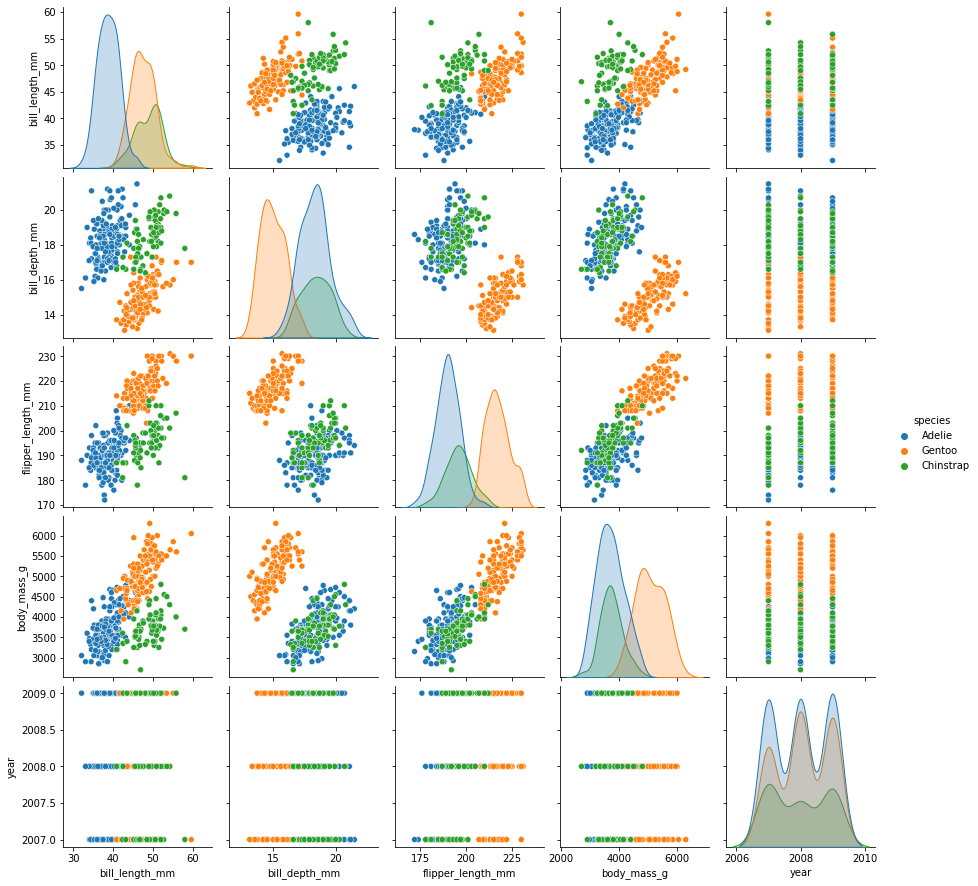

In [8]:
import seaborn as sns

sns.pairplot(df, 
             hue='species', 
             palette="tab10");

In [9]:
df["species"].value_counts() / len(df)

Adelie       0.441860
Gentoo       0.360465
Chinstrap    0.197674
Name: species, dtype: float64

In [10]:
from fastai.tabular.all import (Categorify, CategoryBlock, FillMissing,
                                Normalize, TabDataLoader, TabularPandas,
                                tabular_config, tabular_learner)

procs = [FillMissing, Categorify, Normalize]

In [11]:
from fastcore.foundation import L
from sklearn.model_selection import train_test_split

# shuffle data
df = df.sample(frac=1, random_state=42)

In [12]:
from fastai.data.core import range_of
from fastai.tabular.all import RandomSplitter, TrainTestSplitter

# # train/test split
# splits = RandomSplitter(valid_pct=0.10)(range_of(df))

splits = TrainTestSplitter(test_size=0.20, 
                           train_size=0.80, 
                           random_state=None, 
                           stratify=df["species"].values, 
                           shuffle=True)(range_of(df))

In [13]:
tabular_pandas = TabularPandas(
        df,
        procs=procs,
        cat_names=cat_names,
        cont_names=cont_names,
        y_names=y_names,
        y_block=y_block,
        splits=splits,
        device="cpu")

In [14]:
# from mobius.samplers import ImbalancedDatasetSampler

trn_dl = TabDataLoader(
    tabular_pandas.train,
    bs=16,
    shuffle=True,
    drop_last=True,)

val_dl = TabDataLoader(
    tabular_pandas.valid,
    bs=16,)

In [15]:
from fastai.data.core import DataLoaders

dls = DataLoaders(trn_dl, val_dl)

print("Sample batch:")
dls.one_batch()

Sample batch:


(tensor([[2, 1, 1, 1, 1, 1],
         [2, 1, 1, 1, 1, 1],
         [2, 1, 1, 1, 1, 1],
         [1, 1, 1, 1, 1, 1],
         [2, 1, 1, 1, 1, 1],
         [3, 1, 1, 1, 1, 1],
         [2, 2, 1, 1, 1, 1],
         [1, 1, 1, 1, 1, 1],
         [3, 1, 1, 1, 1, 1],
         [2, 2, 1, 1, 1, 1],
         [2, 1, 1, 1, 1, 1],
         [1, 2, 1, 1, 1, 1],
         [1, 2, 1, 1, 1, 1],
         [2, 2, 1, 1, 1, 1],
         [1, 1, 1, 1, 1, 1],
         [3, 1, 1, 1, 1, 1]]),
 tensor([[ 0.6971,  0.5637, -0.4158, -0.4448,  0.0089],
         [ 0.5688, -0.2777, -0.6304, -1.8906,  0.0089],
         [ 0.4405,  0.1677, -0.9882, -0.6963,  0.0089],
         [-0.3293, -1.8119,  0.6575, -0.0677, -1.2203],
         [-1.3192,  0.6132, -1.2028, -0.9163,  1.2382],
         [-1.6858,  0.0193, -0.8451, -1.2620,  0.0089],
         [ 1.3020,  0.9596, -0.3442, -0.8220,  0.0089],
         [-1.5208, -0.4757, -0.4158, -1.0734,  0.0089],
         [-0.8976,  0.3162, -1.4175, -0.7277, -1.2203],
         [ 1.0821,  0.7121, -0

In [16]:
from fastai.metrics import F1Score, Precision, Recall, accuracy

# load the tabular_pandas data through the tabular_learner
layers = [2048, 1024, 64]

# tabular learner configuration
config = tabular_config(ps=[0.01, 0.01, 0.01], embed_p=0.01)

# create tabular learner
learn = tabular_learner(
    dls,
    layers=layers,
    emb_szs=emb_szs,
    config=config,
    metrics=[accuracy,
             Precision(average='macro'),
             Recall(average='macro'),
             F1Score(average='macro')])

In [17]:
learn.fit_one_cycle(n_epoch=10)

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.483605,0.537369,0.971014,0.965079,0.965079,0.965079,00:00
1,0.235834,0.110609,0.971014,0.965079,0.965079,0.965079,00:00
2,0.178266,0.068426,0.985507,0.977778,0.988889,0.982856,00:00
3,0.147811,0.041992,0.985507,0.989247,0.976190,0.982190,00:00
4,0.122121,0.017697,0.985507,0.989247,0.976190,0.982190,00:00
5,0.102785,0.013457,1.000000,1.000000,1.000000,1.000000,00:00
6,0.089658,0.009333,1.000000,1.000000,1.000000,1.000000,00:00
7,0.091168,0.007673,1.000000,1.000000,1.000000,1.000000,00:00
8,0.084273,0.007591,1.000000,1.000000,1.000000,1.000000,00:00
9,0.076236,0.006604,1.000000,1.000000,1.000000,1.000000,00:00


In [18]:
# lr_min, lr_steep = learn.lr_find()
# print(f"lr min: {lr_min}")
# print(f"lr steep: {lr_steep}")

In [19]:
# learn.fit(n_epoch=5, lr=lr_steep)

In [20]:
learn.export("tabular_learn_wine.pkl")

In [21]:
from mobius.calibration import ModelWithTemperature

scaled_model = ModelWithTemperature(learn.model)
scaled_model.set_temperature(val_dl)
learn.model = scaled_model.model

Before temperature - NLL: 0.007, ECE: 0.006
Optimal temperature: 0.941
After temperature - NLL: 0.005, ECE: 0.005


In [22]:
# true species labels
y_true=learn.dls.valid.items["species"]

# model scores and species predictions
y_scores, *_ = learn.get_preds(dl=val_dl)
preds = np.argmax(y_scores, 1).numpy()

In [23]:
print("First 20 species labels and predictions")
list(zip(y_true, preds))[:10]

First 20 species labels and predictions


[(0, 0),
 (2, 2),
 (0, 0),
 (2, 2),
 (0, 0),
 (1, 1),
 (2, 2),
 (2, 2),
 (0, 0),
 (0, 0)]

In [24]:
(y_true == preds).sum() / len(y_true)

1.0

In [25]:
# TODO: update roc-it with MultiClassClassification...

# clf_metrics = BinaryClassification(
#     y_true=y_true, y_scores=y_scores)

# ths = clf_metrics.recall_curve(0.95)

# clf_metrics.plot_confusion_matrix(
#     ths=0.50,
#     normalize=None,
#     save_path=f'{hyperparams["artifact_dir"]}/cm.png')

# clf_metrics.plot_pr_curve(
#     save_path=f'{hyperparams["artifact_dir"]}/pr_curve.png')

# clf_metrics.plot_roc_curve(
#     save_path=f'{hyperparams["artifact_dir"]}/roc_curve.png')

## Siamese Net

To init a new `TabularSiameseDataset` object, we only need a `tabular_pandas` object from the fast.ai library.

In [26]:
from mobius.datasets import TabularSiameseDataset

# sds = TabularSiameseDataset(tabular_pandas)
train_ds = TabularSiameseDataset(tabular_pandas.train)
valid_ds = TabularSiameseDataset(tabular_pandas.valid)

In [27]:
train_ds.__getitem__(10)

((tensor([2, 2, 1, 1, 1, 1]),
  tensor([ 1.3754,  1.3555, -0.2011, -0.6334, -1.2203])),
 (tensor([2, 1, 1, 1, 1, 1]),
  tensor([-0.0544,  0.4647,  0.0851, -1.0106,  1.2382])),
 tensor(0.))

In [28]:
dls = DataLoaders.from_dsets(train_ds, valid_ds, bs=16, device='cpu', num_workers=0)

Siamese net encoder is the body of the Tabular net we just trained.

In [29]:
import copy

encoder = copy.copy(learn)
encoder.model.layers = learn.model.layers[:-1]
encoder_model = encoder.model

In [30]:
encoder_model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(4, 3)
    (1): Embedding(3, 3)
    (2): Embedding(3, 3)
    (3): Embedding(3, 3)
    (4): Embedding(3, 3)
    (5): Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.01, inplace=False)
  (bn_cont): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): BatchNorm1d(23, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.01, inplace=False)
      (2): Linear(in_features=23, out_features=2048, bias=False)
      (3): ReLU(inplace=True)
    )
    (1): LinBnDrop(
      (0): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.01, inplace=False)
      (2): Linear(in_features=2048, out_features=1024, bias=False)
      (3): ReLU(inplace=True)
    )
    (2): LinBnDrop(
      (0): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0

We create a new head that doubles the input shape to the last layer of the trained Tabular net, since the loss function will now compare 2 penguins. The size of the output shape is set by...???

In [31]:
from fastai.layers import LinBnDrop

head = LinBnDrop(n_in=layers[-1]*2,
    n_out=32,  # size of output space
    bn=True,
    act=None)

In [32]:
head

LinBnDrop(
  (0): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (1): Linear(in_features=128, out_features=32, bias=False)
)

In [33]:
from mobius.models import TabularSiameseModel

model = TabularSiameseModel(encoder_model, head)

In [34]:
# TODO: run grid search over margin... how do we find and start with intelligent margins?
# ... instead of relying on brute force searching?

In [35]:
from fastai.torch_basics import params
from mobius.losses import ContrastiveLoss

def siamese_splitter(model):
    return [params(model.encoder), params(model.head)]

def contrastive_loss_func(out, targ):
    return ContrastiveLoss(margin=0.10)(out, targ.long())

In [36]:
from fastai.callback.core import Callback

class BatchCounter(Callback): 
    def begin_epoch(self, epoch):
        self.epoch=epoch
        self.batch_counter = 1
        return True
        
    def after_step(self):
        self.batch_counter += 1
        if self.batch_counter % 200 == 0: print(f'Batch {self.batch_counter} completed')
        return True
    
class TimeCheck(Callback):
    def begin_fit(self, learn):
        self.learn = learn
        self.epoch_counter = 1
        return True
    
    def begin_epoch(self, epoch):
        self.epoch=epoch
        print(f'Epoch {self.epoch_counter} started at {time.strftime("%H:%M:%S", time.gmtime())}')
        self.epoch_counter += 1
        return True 
        
class PrintLoss(Callback):
    def after_epoch(self):
        print(f'Loss: {self.loss}')
        return True

In [37]:
class CallbackHandler():
    def __init__(self,cbs=None):
        self.cbs = cbs if cbs else []

    def begin_fit(self, learn):
        self.learn,self.in_train = learn,True
        learn.stop = False
        res = True
        for cb in self.cbs: res = res and cb.begin_fit(learn)
        return res

    def after_fit(self):
        res = not self.in_train
        for cb in self.cbs: res = res and cb.after_fit()
        return res
    
    def begin_epoch(self, epoch):
        learn.model.train()
        self.in_train=True
        res = True
        for cb in self.cbs: res = res and cb.begin_epoch(epoch)
        return res

    def begin_validate(self):
        self.learn.model.eval()
        self.in_train=False
        res = True
        for cb in self.cbs: res = res and cb.begin_validate()
        return res

In [38]:
from fastai.learner import Learner

siamese_learner = Learner(dls,
    model,
    model_dir=".",
    loss_func=contrastive_loss_func,
    splitter=siamese_splitter)

# siamese_learner.add_cbs(BatchCounter())

lr min: 0.0019054606556892395
lr steep: 6.309573450380412e-07


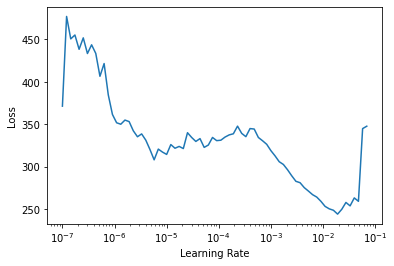

In [39]:
# %debug
# siamese_learner.unfreeze()
lr_min, lr_steep = siamese_learner.lr_find()
print(f"lr min: {lr_min}")
print(f"lr steep: {lr_steep}")

In [100]:
siamese_learner.fit(n_epoch=10, lr=lr_min)

epoch,train_loss,valid_loss,time
0,4.210382,4.637712,00:08
1,5.753815,8.275901,00:07
2,6.279381,6.841781,00:08
3,5.897285,3.580333,00:07
4,5.761641,2.225557,00:07
5,4.969535,2.484694,00:07
6,5.379562,3.724554,00:07
7,5.218283,1.492690,00:07
8,4.872220,4.553929,00:08
9,4.896903,3.466041,00:08


In [101]:
# siamese_learner.unfreeze()

# lr_min, _ = siamese_learner.lr_find()
# siamese_learner.fit(n_epoch=3, lr=lr_min)

In [102]:
# siamese_learner.save("snn_margin_20_wine")

In [103]:
from tqdm import tqdm

train_encoded = list()
for i in tqdm(range(len(dls.train_ds.tabular_pandas))):
    # get ith point from the training set
    p, _, _ = dls.train_ds.get_items(i, 0)

    # rehsape into mini-batch size 1
    p = p[0].reshape(1, -1), p[1].reshape(1, -1)

    # encode the household into output embedding space
    p_encode = siamese_learner.model.encode(p)
    train_encoded.append(p_encode)
    
ids = dls.train.get_idxs()
y_train_labels = dls.train.tabular_pandas["species"]

100%|██████████| 275/275 [00:12<00:00, 22.36it/s]


In [104]:
import torch
import pandas as pd

train_encoded_df = pd.DataFrame(torch.stack(train_encoded).squeeze())

In [105]:
train_encoded_df

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,11.266243,0.000000,0.000000,0.000000,0.288704
1,12.265818,9.765398,7.668836,0.000000,12.950691,12.251197,12.439234,0.000000,0.000000,0.000000,...,11.553835,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.141800,17.121124
2,0.000000,0.000000,0.000000,7.318179,0.000000,0.000000,0.000000,12.363782,6.439137,11.343615,...,0.000000,11.100203,11.742349,8.911390,11.803859,0.000000,7.056103,11.657295,0.000000,0.000000
3,0.000000,0.000000,0.000000,5.921105,0.000000,0.000000,0.000000,11.443808,6.548019,9.341360,...,0.000000,10.176697,12.067893,8.503339,9.279387,0.000000,6.760044,10.347357,0.000000,0.000000
4,11.837256,9.138479,7.567915,0.000000,12.378953,11.428785,12.090660,0.000000,0.000000,0.000000,...,11.122477,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.902065,16.586105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270,0.349922,1.243087,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,13.073076,0.000000,0.000000,0.394691,0.509868
271,10.581734,8.933182,6.309215,0.000000,11.387810,10.865328,10.524763,0.000000,0.000000,0.000000,...,9.787848,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.860279,15.278750
272,0.000000,0.000000,0.000000,12.547953,0.000000,0.000000,0.000000,18.004112,19.308317,21.079332,...,0.000000,16.281651,24.499008,12.900024,17.027824,0.000000,14.346909,20.771523,0.000000,0.000000
273,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,13.125536,0.000000,0.000000,0.000000,0.000000


In [106]:
# train_encoded_df[0].values

In [107]:
# !pip install seaborn

In [108]:
# import seaborn as sns
# from sklearn.manifold import TSNE
# sns.set(rc={'figure.figsize':(11.7,8.27)})

# sns.scatterplot(x=train_encoded_df[0].values,
#                 y=train_encoded_df[1].values,
#                 hue=y_train_labels, 
#                 legend='full', 
#                 palette="tab10")

In [109]:
import seaborn as sns
from sklearn.manifold import TSNE
sns.set(rc={'figure.figsize':(11.7,8.27)})

tsne = TSNE()
encoded_train_tsne = tsne.fit_transform(train_encoded_df.values)

In [110]:
# sns.scatterplot(x=encoded_train_tsne[:,0],
#                 y=encoded_train_tsne[:,1],
#                 hue=y_train_labels, 
#                 legend='full', 
#                 palette="tab10")

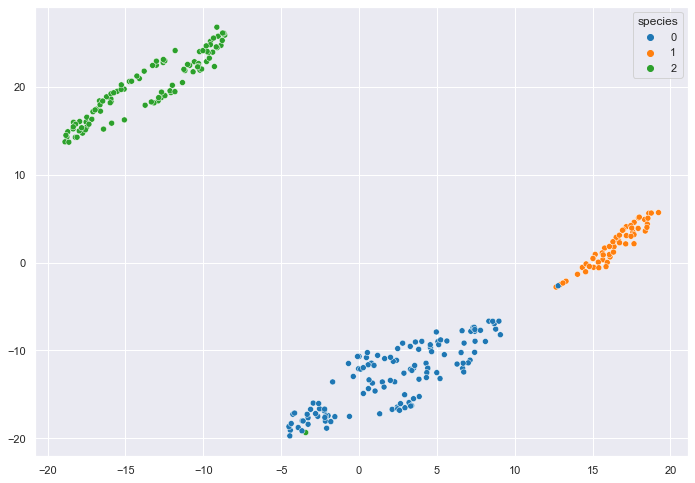

In [111]:
sns.scatterplot(x=encoded_train_tsne[:,0],
                y=encoded_train_tsne[:,1],
                hue=y_train_labels, 
                legend='full', 
                palette="tab10").figure.savefig(f"margin_010_epoch_35.png")

# TODO: use embedded space to better predict quality

In [ ]:
from sklearn.metrics import f1_score, make_scorer
f1 = make_scorer(f1_score , average='macro')

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

parameters = {
    "learning_rate": [1e-1, 1e-2, 1e-3],
    "max_depth":[3, 5, 8, 10],
    "n_estimators":[50, 100]
    }

clf = GridSearchCV(GradientBoostingClassifier(), parameters, scoring=f1, cv=5, n_jobs=-1)
clf.fit(train_encoded_df.values, y_train_labels)

print(clf.score(train_encoded_df.values, y_train_labels))
print(clf.best_params_)

## Experiment: Clustering Approach

In [ ]:
# from sklearn.cluster import AgglomerativeClustering
# import numpy as np

# # TODO: grid search this...
# clustering = AgglomerativeClustering(
#     n_clusters=8, 
#     affinity="l1", 
#     linkage="complete").\
# fit(train_encoded_df.values)

# clustering.labels_

In [ ]:
# res = pd.DataFrame(zip(y_train_labels, clustering.labels_), columns=["true", "pred"])

In [ ]:
# res_counts = res.groupby(["true", "pred"]).apply(len).reset_index()
# res_counts.columns = ["true", "pred", "count"]

In [ ]:
# # TODO: order the below for loops to start with largest clusters first
# res_counts

In [ ]:
# cluster2label = dict()
# for pred in res_counts["pred"].unique():
#     thingy = res_counts[res_counts["pred"] == pred].sort_values("count", ascending=False)
    
#     for label in thingy["true"].values:
#         if label not in cluster2label.values():
#             cluster2label.update({pred: label})
    
# for pred in res_counts["pred"].unique():
#     if pred not in cluster2label.keys():
#         cluster2label.update({pred: None})

In [ ]:
# cluster2label

In [ ]:
# cluster_groups = res.groupby(["true", "pred"]).apply(len).reset_index().values
# cluster_groups

## Validation Set

In [ ]:
from tqdm import tqdm

valid_encoded = list()
for i in tqdm(range(len(dls.valid_ds.tabular_pandas))):
    # get ith point from the training set
    p, _, _ = dls.valid_ds.get_items(i, 0)

    # rehsape into mini-batch size 1
    p = p[0].reshape(1, -1), p[1].reshape(1, -1)

    # encode the household into output embedding space
    p_encode = siamese_learner.model.encode(p)
    valid_encoded.append(p_encode)
    
valid_ids = dls.valid.get_idxs()
y_valid_labels = dls.valid.tabular_pandas["loan_status"]

In [ ]:
valid_encoded_df = pd.DataFrame(torch.stack(valid_encoded).squeeze())

In [ ]:
encoded_valid_tsne = tsne.fit_transform(valid_encoded_df.values)

In [ ]:
sns.scatterplot(x=encoded_valid_tsne[:,0],
                y=encoded_valid_tsne[:,1],
                hue=y_valid_labels, 
                legend='full', 
                palette="tab10")

In [ ]:
res = pd.DataFrame(zip(clf.predict(valid_encoded_df), y_valid_labels), columns=["pred", "true"])

In [ ]:
(res["pred"] == res["true"]).sum() / len(res)

In [ ]:
res

In [ ]:
from sklearn.metrics import precision_recall_fscore_support as multiclass_eval

prec, recall, fbeta, _ = multiclass_eval(res["true"].values, res["pred"].values, average="macro")

f"precision {prec}, recall {recall}, fbeta {fbeta}"

In [ ]:
# import umap
# import matplotlib.pyplot as plt

# reducer = umap.UMAP()

# embedding = reducer.fit_transform(valid_encoded_df.values)
# embedding.shape

# plt.scatter(
#     embedding[:, 0],
#     embedding[:, 1],
#     c=[sns.color_palette()[x] for x in y_valid_labels.values])

# plt.gca().set_aspect('equal', 'datalim')
# plt.title('UMAP projection of the LC Loans', fontsize=24)